In [1]:
import os, sys, time
# Reference: https://stackoverflow.com/questions/34478398/import-local-function-from-a-module-housed-in-another-directory-with-relative-im
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from importlib import reload

import numpy as np
import pandas  as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import homogeneity_score


import common
import DimensionalityReduction.DimensionalityReductionDatasets as dr_datasets
from data.generated.generated_data import get_noisy_nonlinear_with_non_noisy_labels

title_fontsize = 24
fontsize = 24
legend_fontsize = 18
default_figure_size = (15, 8)

DATASET = "Generated Non-Linear"

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/pandas/core/frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [22]:
X_train_gnnl, X_test_gnnl, y_train_gnnl, y_test_gnnl, y_test_non_noisy_gnnl =\
get_noisy_nonlinear_with_non_noisy_labels()

reload(dr_datasets)
_, pca_gnnl = dr_datasets.get_gnnl_pca()

Running PCA for 5 components


/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/pandas/core/frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [11]:
pca_gnnl.shape[1]

5

In [12]:
reload(common)
n = pca_gnnl.shape[1]
distortions, davies_bouldin_scores, silhouette_scores, calinski_harabasz_scores, times =\
common.compute_kmeans_scores(pca_gnnl, n)

For n_clusters = 2 average silhouette_score: 0.6863194254680295 time taken: 0.12191438674926758s
For n_clusters = 3 average silhouette_score: 0.6145807011762534 time taken: 0.07909703254699707s
For n_clusters = 4 average silhouette_score: 0.5692430861753597 time taken: 0.06899476051330566s
For n_clusters = 5 average silhouette_score: 0.6298529001812114 time taken: 0.08411169052124023s


/media/richard/Data/CloudStation/Masters Degree/GATechOMSCS_CourseWork/CS7641-Machine_Learning/UnsupervisedLearning_Project_Code/common.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  host = fig.add_subplot(111)


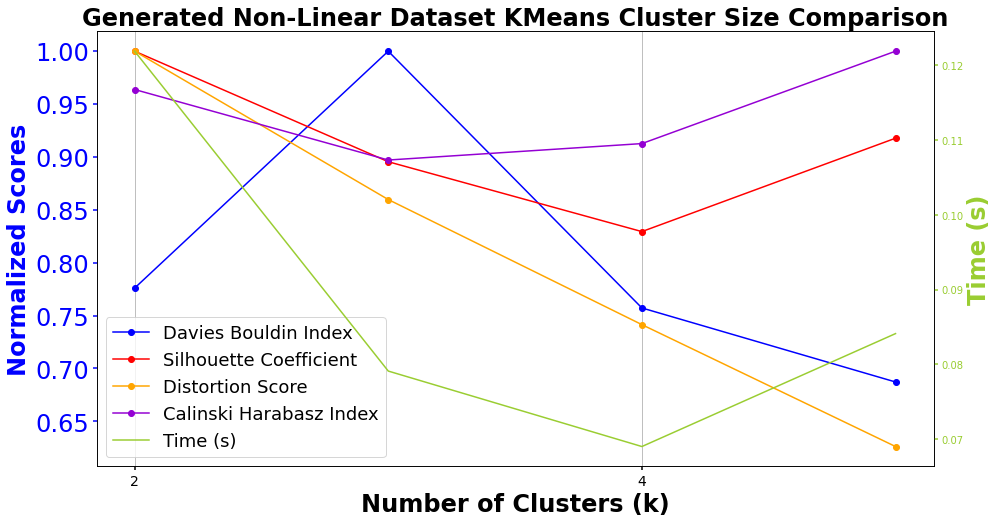

In [13]:
common.plot_kmeans_all(distortions, davies_bouldin_scores, silhouette_scores, calinski_harabasz_scores, times, DATASET)

/media/richard/Data/CloudStation/Masters Degree/GATechOMSCS_CourseWork/CS7641-Machine_Learning/UnsupervisedLearning_Project_Code/common.py:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  host = fig.add_subplot(111)


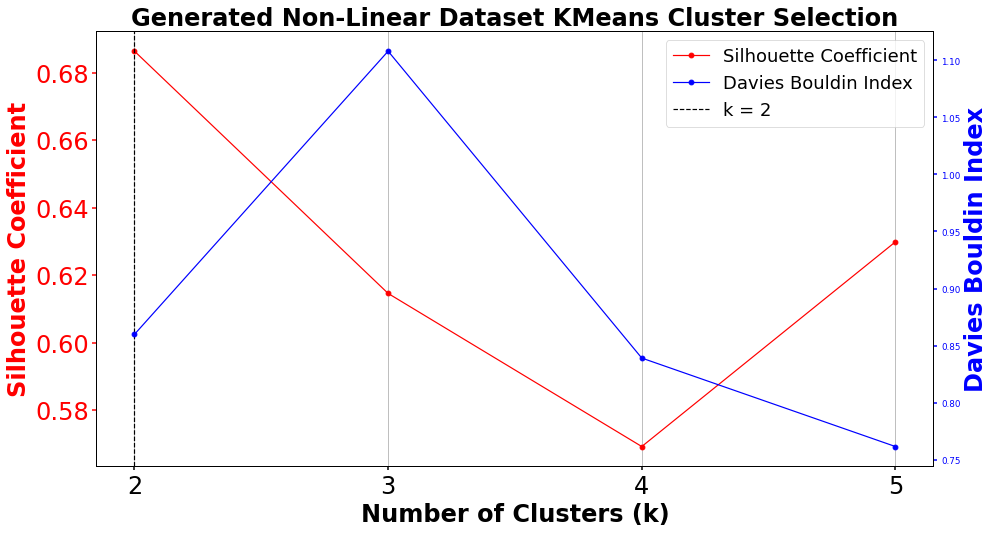

In [64]:
reload(common)
best_k = 2
common.plot_kmeans_selection(davies_bouldin_scores, silhouette_scores, best_k=best_k, DATASET=DATASET, tick_spacing=1)

For n_clusters = 2 average silhouette_score: 0.6863194254680295 time taken: 0.22139549255371094s


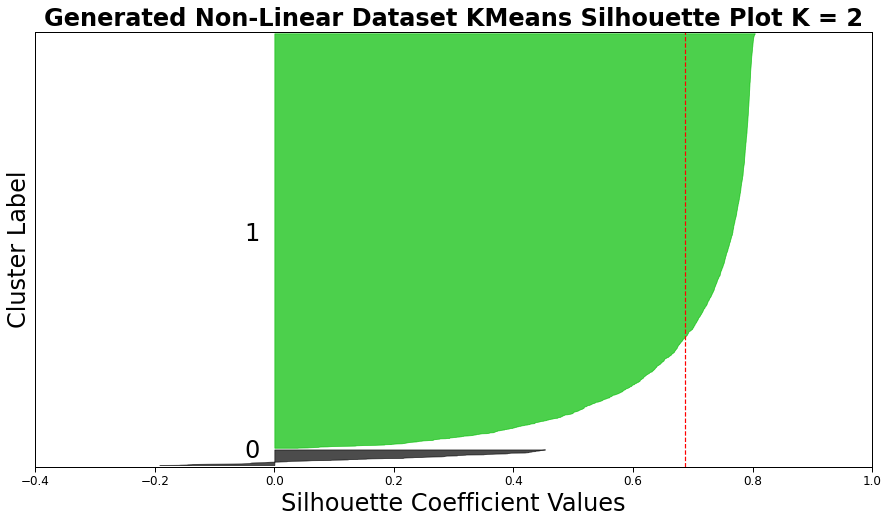

In [65]:
reload(common)
common.plot_silhouette_kmeans(pca_gnnl, best_k, DATASET, xlim=[-0.4, 1.0])

In [23]:
y_train_gnnl_df = pd.DataFrame(y_train_gnnl, columns=["data_labels"])

start_time = time.time()
km = KMeans(n_clusters=best_k, **common.km_arguements)
km.fit(pca_gnnl)
end_time = time.time()
print("Time Taken {} s".format(end_time - start_time))
y_train_gnnl_df['km_labels']=km.labels_
pca_gnnl_km = pd.DataFrame(pca_gnnl.copy())
pca_gnnl_km['km_labels'] = km.labels_

print("homogeneity_score: ", homogeneity_score(km.labels_, y_train_gnnl))

Time Taken 0.1696946620941162 s
homogeneity_score:  0.005852296112770827


In [25]:
# Create a t-SNE model with learning rate 50
m = TSNE(perplexity=30, learning_rate=50)

# Fit and transform the t-SNE model on the numeric dataset
tsne_features = m.fit_transform(pca_gnnl)
y_train_gnnl_df['x'] = tsne_features[:,0]
y_train_gnnl_df['y'] = tsne_features[:,1]

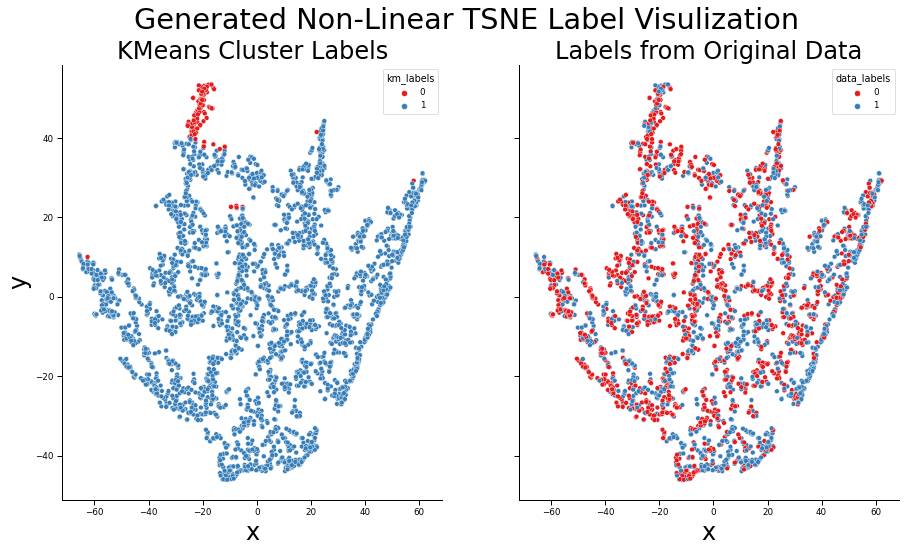

In [26]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=default_figure_size, sharey=True)

sns.set_context("paper", rc={"font.size": fontsize, "axes.titlesize": fontsize, "axes.labelsize": fontsize})

sns.scatterplot(x="x", y="y", hue="km_labels", data=y_train_gnnl_df, palette="Set1", ax=ax1)
sns.scatterplot(x="x", y="y", hue="data_labels", data=y_train_gnnl_df, palette="Set1", ax=ax2)

fig.suptitle("{} TSNE Label Visulization".format(DATASET))
ax1.set_title("KMeans Cluster Labels")
ax2.set_title("Labels from Original Data")
sns.despine(fig)

plt.show()

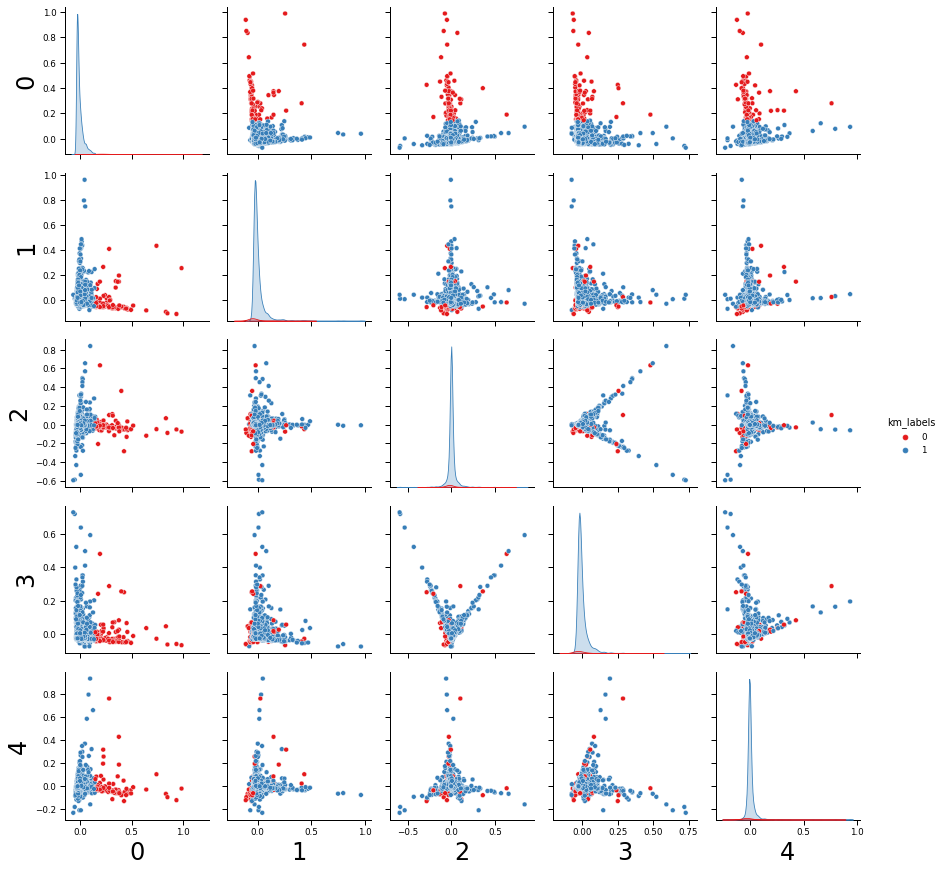

In [28]:
sns.pairplot(pca_gnnl_km, hue="km_labels", palette="Set1")

# Expectation Maximization

In [48]:
reload(common)
em_n = pca_gnnl.shape[1]
n_components = np.arange(2, em_n)
davies_bouldin_scores_em, silhouette_scores_em, bic_scores_em, aic_scores_em, times_em =\
common.compute_em_scores(pca_gnnl, em_n)

For n_clusters = 2 average silhouette_score: 0.39989104408445536 time taken: 0.7538397312164307s
For n_clusters = 3 average silhouette_score: 0.3417646527262101 time taken: 0.18149328231811523s
For n_clusters = 4 average silhouette_score: 0.19637238829627887 time taken: 0.224440336227417s
For n_clusters = 5 average silhouette_score: 0.052495879545057855 time taken: 0.30712342262268066s


/media/richard/Data/CloudStation/Masters Degree/GATechOMSCS_CourseWork/CS7641-Machine_Learning/UnsupervisedLearning_Project_Code/common.py:250: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  host = fig.add_subplot(111)


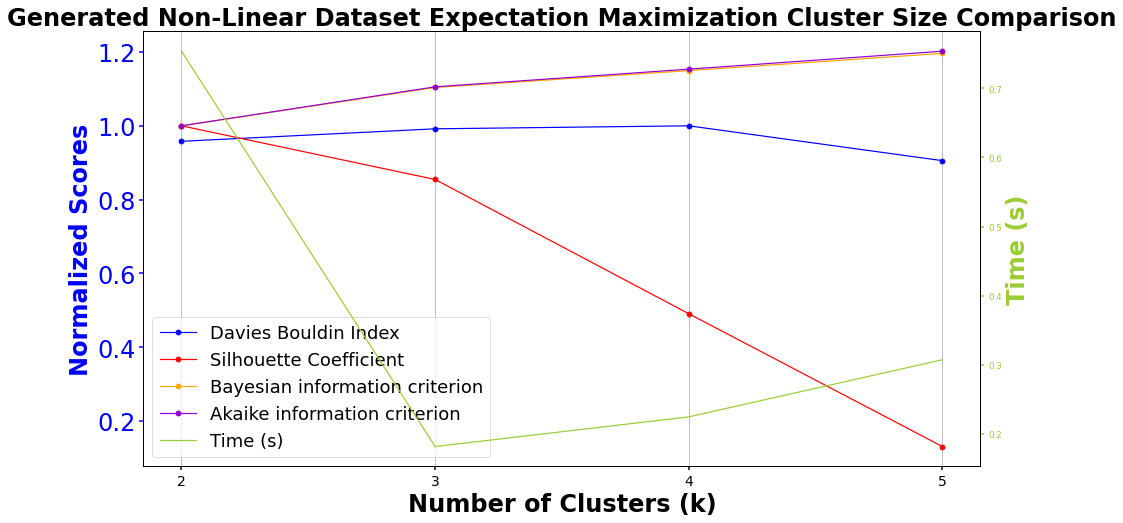

In [49]:
reload(common)
common.plot_em_all(davies_bouldin_scores_em, silhouette_scores_em, bic_scores_em, aic_scores_em, times_em, DATASET)

/media/richard/Data/CloudStation/Masters Degree/GATechOMSCS_CourseWork/CS7641-Machine_Learning/UnsupervisedLearning_Project_Code/common.py:301: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  host = fig.add_subplot(111)


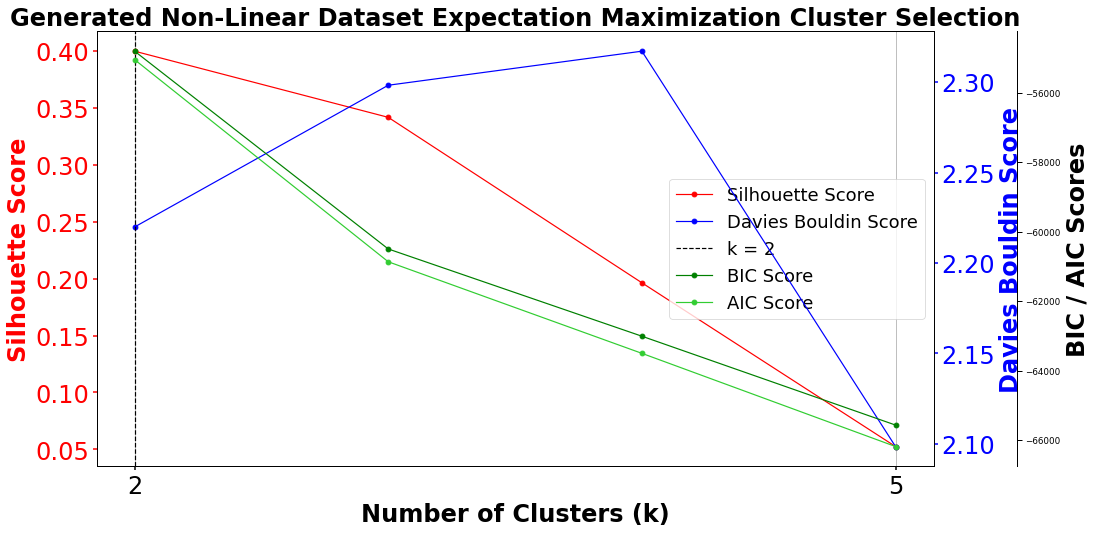

In [50]:
reload(common)
best_k = 2
common.plot_em_selection(davies_bouldin_scores_em, silhouette_scores_em, bic_scores_em, aic_scores_em, best_k, DATASET, tick_spacing=3)

For n_clusters = 2 average silhouette_score: 0.39989104408445536 time taken: 0.1462109088897705s


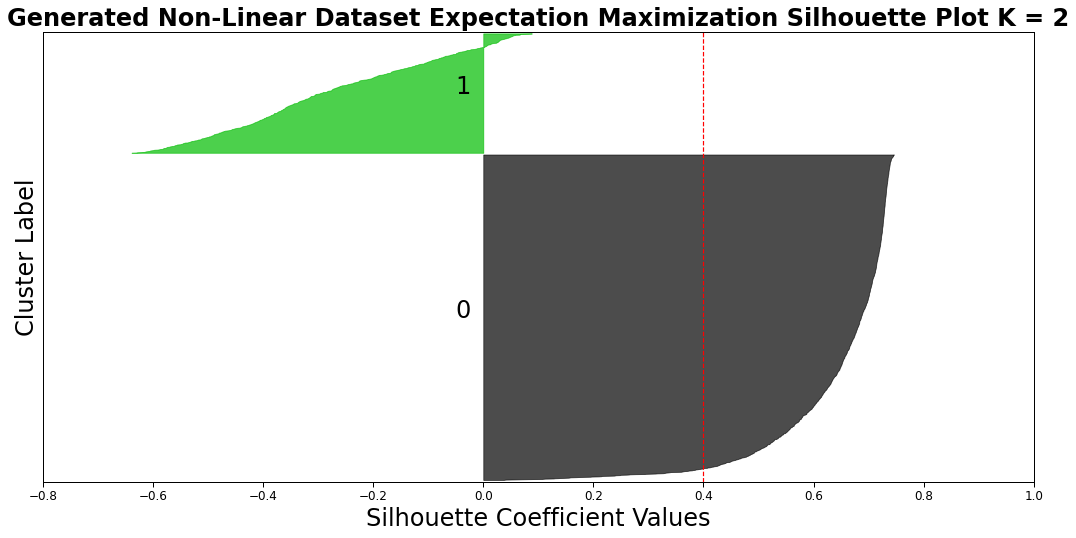

In [58]:
reload(common)
best_k=2
common.plot_silhouette_em(pca_gnnl, best_k, DATASET, xlim=[-0.8, 1.0])

In [53]:
y_train_gnnl_df = pd.DataFrame(y_train_gnnl, columns=["data_labels"])

start_time = time.time()
em_model = GaussianMixture(best_k, **common.em_arguements)
em_model.fit(pca_gnnl)
end_time = time.time()
print("time taken {} s".format(end_time-start_time))
y_train_gnnl_df['em_labels']=em_model.predict(pca_gnnl)
pca_gnnl_em = pd.DataFrame(pca_gnnl.copy())
pca_gnnl_em['em_labels'] = em_model.predict(pca_gnnl)

print("homogeneity_score: ", homogeneity_score(em_model.predict(pca_gnnl), y_train_gnnl))


time taken 0.15114593505859375 s
homogeneity_score:  0.000923933703331837


In [54]:
# Create a t-SNE model with learning rate 50
m = TSNE(perplexity=30, learning_rate=50)

# Fit and transform the t-SNE model on the numeric dataset
tsne_features = m.fit_transform(pca_gnnl)
y_train_gnnl_df['x'] = tsne_features[:,0]
y_train_gnnl_df['y'] = tsne_features[:,1]

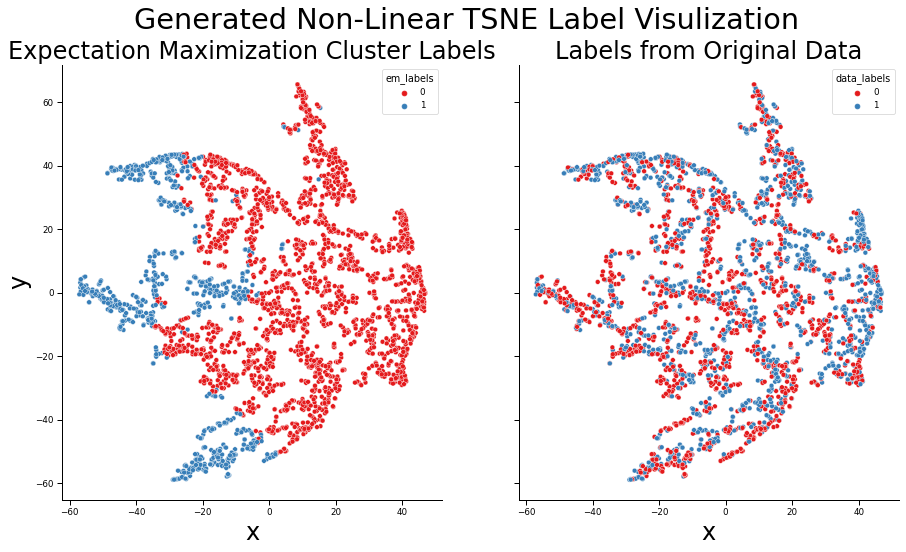

In [55]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=default_figure_size, sharey=True)

sns.set_context("paper", rc={"font.size": fontsize, "axes.titlesize": fontsize, "axes.labelsize": fontsize})

sns.scatterplot(x="x", y="y", hue="em_labels", data=y_train_gnnl_df, palette="Set1", ax=ax1)
sns.scatterplot(x="x", y="y", hue="data_labels", data=y_train_gnnl_df, palette="Set1", ax=ax2)

fig.suptitle("{} TSNE Label Visulization".format(DATASET))
ax1.set_title("Expectation Maximization Cluster Labels")
ax2.set_title("Labels from Original Data")
sns.despine(fig)

plt.show()

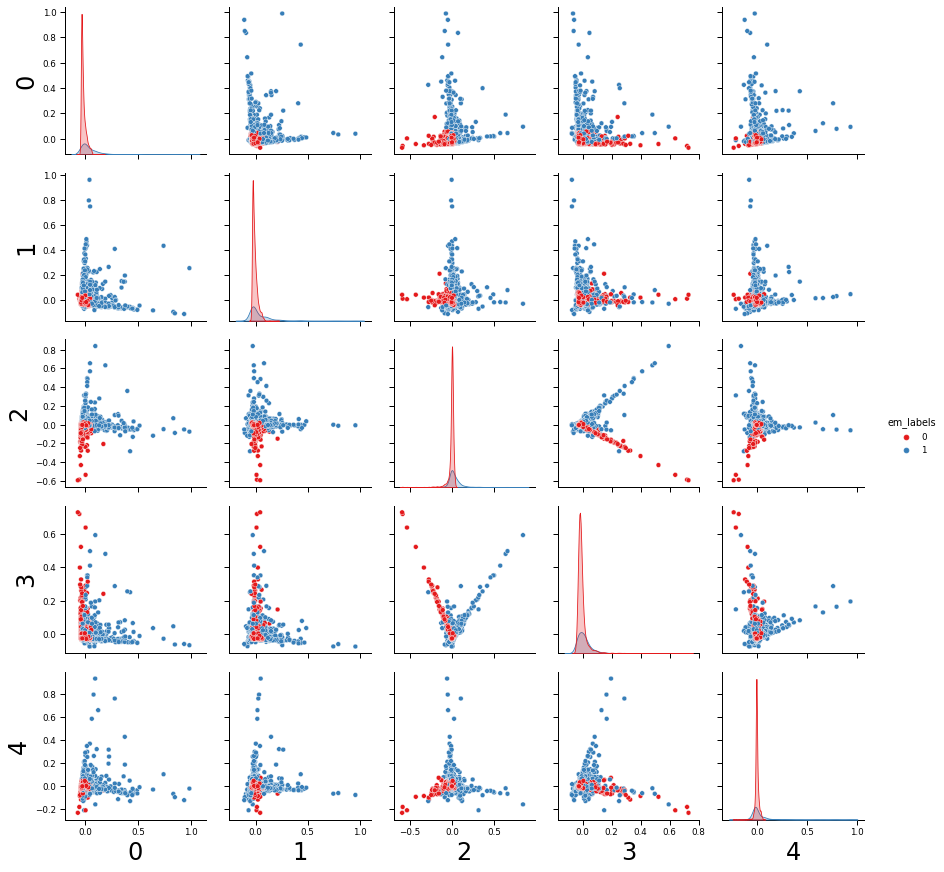

In [56]:
sns.pairplot(pca_gnnl_em, hue="em_labels", palette="Set1")